# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from random import randint
import matplotlib.pyplot as plt 
import itertools

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
from numpy.random import RandomState

state = RandomState(12345) 

df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')

# отобразим все столбцы в датасете
pd.set_option('display.max_columns', None)

In [2]:
# создадим универсальную функцию, которая будет принимать на вход датафрейм, 
# а на выходе она будет выводить все его нужные характеристики, пока достаточно head и info
def df_information(df): 
    display(df.head()) 
    print('Количество дубликатов:', df.duplicated().sum())
    return df.info()

# занесем все датафреймы в словарь
df_list = {'region1': df0, 
           'region2': df1, 
           'region3': df2
          }

# применим функцию ко всем датафреймам
for key in df_list:
    print('Информация о датафрейме', key) 
    df_information(df_list[key])
    print('\n')
    

Информация о датафрейме region1


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Количество дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Информация о датафрейме region2


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Количество дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Информация о датафрейме region3


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Количество дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB




Данные состоят из трех таблиц, сопоставленных геологоразведке трех регионов. В столбцах использованы типы данных `float64` и `object`. 
Пропуски в данных отсутствуют. Дубликаты в данных отсутствуют.

Описание столбцов:
    
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

Посмотри на описательную статистику данных по трем регионам:

In [3]:
def df_describe(df): 
    return display(df.describe())

# занесем все датафреймы в словарь
df_list = {'region1': df0, 
           'region2': df1, 
           'region3': df2
          }

# применим функцию ко всем датафреймам
for key in df_list:
    print('Описательная статистика по', key) 
    df_describe(df_list[key])
    print('\n')

Описательная статистика по region1


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347




Описательная статистика по region2


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408




Описательная статистика по region3


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


В основном медианные значения близки к средним и скошенности в данных не наблюдается нигде, кроме признака f2 для второго региона. Для f2 во втором регионе наблюдаем скошенность данных вправо: медиана меньше среднего на 19%. 

Теперь визуализируем распределения данных, посмотрим выбросы на диаграмме размаха. 

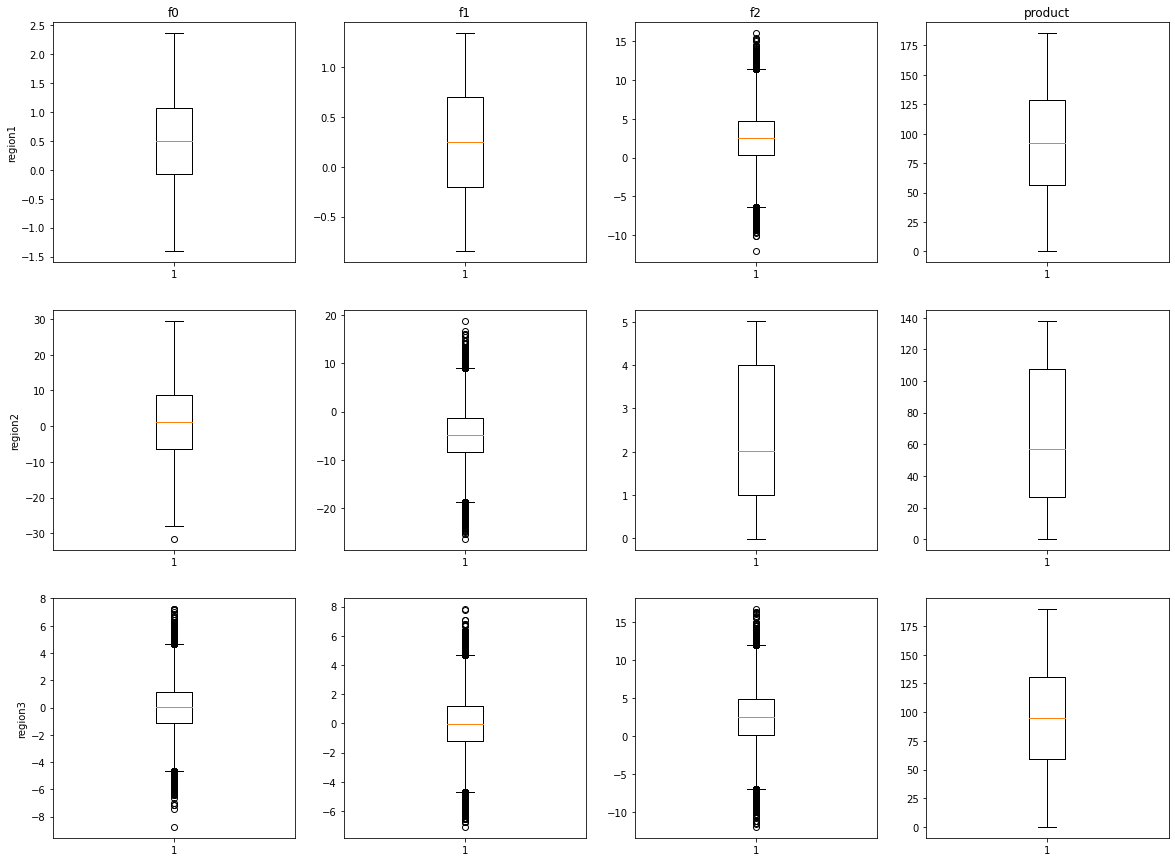

In [4]:
fig,ax = plt.subplots(3,4,figsize = (20,15))

all_frames = ['region1', 'region2', 'region3']
num_columns = df0.columns[1:]
num_columns_with_columns = zip(df0.columns[1:],range(4))
all_frames_with_rows = zip([df0,df1,df2],range(3))
# Построим графики
for column in list(itertools.product(all_frames_with_rows,num_columns_with_columns)):
    ax[column[0][1]][column[1][1]].boxplot(column[0][0][column[1][0]])
# Добавим название фрейма изображаемого на графике
for row in range(3):
    ax[row][0].set_ylabel(all_frames[row])
# Добавим название столбца изображаемого на графике
for column in range(4):
    ax[0][column].set_title(num_columns[column])

Из графика видно, что выбросы есть в каждом регионе, но убирать их не будем. Также не будем проверять корреляцию признаков. Данные проекта синтетические. Корреляции у признаков есть, но преподаватель по проекту предложил не обращать на это внимания.

## Обучение и проверка модели

Построим модель для каждого региона. Как сказано в условии задачи, для обучения модели подходит только линейная регрессия. 

In [5]:
name_list = ['region1', 'region2', 'region3']

df_list = [df0, df1, df2]

data_dict = {'models':{},'scores':{},'valid':{}}

for frame, name in zip(df_list,name_list):
    
    features = frame.drop(['id', 'product'], axis = 1)
    target = frame['product']
    
    model = LinearRegression()
    
    # разобьем данные на обучающую и валидационную выборки в соотношении 75:25
    
    (features_train,
    features_valid,
    target_train,
    target_valid) = train_test_split(features,
                                     target,
                                     test_size = 0.25,
                                     random_state = 12345)
    data_dict['valid'][name] = (features_valid,target_valid)
    
    # обучим модель
    model.fit(features_train,target_train)
    
    data_dict['models'][name] = model
    
    # сделаем предсказания на валидационной выборке, посчитаем RMSE модели
    data_dict['scores'][name] = mean_squared_error(target_valid,
                                                   model.predict(features_valid))**0.5

In [6]:
data_dict['scores']

{'region1': 37.5794217150813,
 'region2': 0.893099286775617,
 'region3': 40.02970873393434}

Самая маленькая среднеквадратичная ошибка получена для второго региона, самая большая - для третьего.

In [7]:
model0 = data_dict['models']['region1']
model1 = data_dict['models']['region2']
model2 = data_dict['models']['region3']

predicted_values0 = model0.predict(data_dict['valid']['region1'][0])
predicted_values1 = model1.predict(data_dict['valid']['region2'][0])
predicted_values2 = model2.predict(data_dict['valid']['region3'][0])

RMSE_model0 = (mean_squared_error(data_dict['valid']['region1'][1],predicted_values0))**0.5
RMSE_model1 = (mean_squared_error(data_dict['valid']['region2'][1],predicted_values1))**0.5
RMSE_model2 = (mean_squared_error(data_dict['valid']['region3'][1],predicted_values2))**0.5

In [8]:
print('Первый регион')
print('Средний запас:', predicted_values0.mean())
print('RMSE модели:', RMSE_model0)
print('\n')
print('Второй регион') 
print('Средний запас:', predicted_values1.mean())
print('RMSE модели:', RMSE_model1)
print('\n')
print('Третий регион')
print('Средний запас:', predicted_values2.mean())
print('RMSE модели:', RMSE_model2)

Первый регион
Средний запас: 92.59256778438035
RMSE модели: 37.5794217150813


Второй регион
Средний запас: 68.728546895446
RMSE модели: 0.893099286775617


Третий регион
Средний запас: 94.96504596800489
RMSE модели: 40.02970873393434


**Первый регион:**
Находится на втором месте по размеру средней квадратичной ошибки и по размеру средних запасов сырья.

**Второй регион:**
Самая маленькая средняя квадратичная ошибка, но и средний запас предсказанного сырья тоже самый маленький.

**Третий регион:**
Самый большой средний объем запасов и самая большая ошибка. 

## Подготовка к расчёту прибыли

In [9]:
# сохраним в отдельных переменных все ключевые значения для расчетов, заданные в условии задачи
BUDGET = 10**10 
MAX_POINTS = 500
POINTS_FOR_DEVELOP = 200
PRICE_PER_1000BARREL = 450000
RISK_PROB =  0.025

In [10]:
AIM_VOLUME = (BUDGET / PRICE_PER_1000BARREL) / (POINTS_FOR_DEVELOP)

In [11]:
print("Достаточный объем добычи сырья для безубыточной разработки:", round(AIM_VOLUME, 2))

Достаточный объем добычи сырья для безубыточной разработки: 111.11


In [12]:
print("25% скважин в первом регионе содержат сырья:",
      round(df0['product'].quantile(0.75),2))
print("16% скважин в втором регионе содержат сырья:",
      round(df1['product'].quantile(0.84),2))
print("25% скважин в третьем регионе содержат сырья:",
      round(df2['product'].quantile(0.75),2))

25% скважин в первом регионе содержат сырья: 128.56
16% скважин в втором регионе содержат сырья: 134.77
25% скважин в третьем регионе содержат сырья: 130.6


Бюджет (10 млрд рублей) мы разделили на Доход с каждой 1000 баррелей (450 тыс рублей = 450 * 1000 баррелей) и затем разделили на 200 (кол-во) скважин, которые в итоге будут выбраны для разработки. Мы получаем средний запас для каждой скважины, чтобы выйти в ноль по бюджету. Таким образом, в среднем скважина должна давать 112 тысяч баррелей (округлила в большую сторону) для того, чтобы не быть убыточной. 

Если сравнить безубыточный объем сырья со средним запасом в каждом регионе, то получается, что в каждом регионе средний запас сырья меньше безубыточного. Максимальный средний запас в третьем регионе и равен он 95 тыс. баррелей на скважину, что не дотягивает до требуемых 112 тыс. баррелей на скважину для того, чтобы выйти в плюс по прибыли.

Если обратить внимание на распределение объема запасов по региону на основании 3-его квантиля, можно заметить, что в первом и третьем регионах 25% скважин проходят минимальный порог безубыточности. Выше порога 3-его квантиля в первом и третьем регионах находятся 25000 и 27000 скважин, соответственно. 200 самых прибыльных скважин для разработки есть из чего выбрать. 

В то время как во втором регионе 3-ий квантиль не достигает порога в 112 тысяч баррелей. Порог удается пересечь только для 16% скважин, что соответствует количеству 16500 скважин, то есть 200 лучших скважин для разработки также будет возможность отобрать.

## Расчёт прибыли и рисков 

Напишем функцию для расчета прибыли по выбранным скважинам и предсказаниям модели, для этого:

1. Выберем скважины с максимальными значениями предсказаний.
2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
3. Рассчитаем прибыль для полученного объёма сырья

In [13]:
def profit(true_target, pred_target):
    sort_Series = pd.Series(pred_target).sort_values(ascending=False)[:POINTS_FOR_DEVELOP] #200
    true_target_sort = (true_target
                         .reset_index(drop = True)[sort_Series.index])
    sum_true = true_target_sort.sum() 
    return round((sum_true * PRICE_PER_1000BARREL) - BUDGET, 2)

In [14]:
print('Прибыль с лучших 200 скважин в первом регионе:', profit(data_dict['valid']['region1'][1], predicted_values0))

print('Прибыль с лучших 200 скважин во втором регионе:',profit(data_dict['valid']['region2'][1], predicted_values1))

print('Прибыль с лучших 200 скважин в третьем регионе:',profit(data_dict['valid']['region3'][1], predicted_values2))

Прибыль с лучших 200 скважин в первом регионе: 3320826043.14
Прибыль с лучших 200 скважин во втором регионе: 2415086696.68
Прибыль с лучших 200 скважин в третьем регионе: 2710349963.6


Затем посчитаем риски и прибыль для каждого региона:
1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
2. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [15]:
def confidence_interval(true_target,pred_target):
    values = []
    for i in range(1000):
        subsample = pd.Series(pred_target).sample(n = MAX_POINTS, replace=True, random_state=state)
        values.append(profit(true_target,subsample))
    values = pd.Series(values)
    print('Cредняя прибыль:', round(values.mean(),2))
    print('Риск убытков, т.е. доля отрицательной прибыли среди общей выручки:', 
          round((values < 0).mean()*100,2),"%")
          
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    return round(lower,2), round(upper,2)

In [16]:
print("95% доверительный интервал для первого региона лежит между:",
      confidence_interval(data_dict['valid']['region1'][1], pd.Series(predicted_values0)))
print()
print("95% Доверительный интервал для второго региона лежит между:",
      confidence_interval(data_dict['valid']['region2'][1], predicted_values1))
print()
print("95% Доверительный интервал для третьего региона лежит между:",
      confidence_interval(data_dict['valid']['region3'][1], predicted_values2))

Cредняя прибыль: 396164984.8
Риск убытков, т.е. доля отрицательной прибыли среди общей выручки: 6.9 %
95% доверительный интервал для первого региона лежит между: (-111215545.89, 909766941.55)

Cредняя прибыль: 461155817.28
Риск убытков, т.е. доля отрицательной прибыли среди общей выручки: 0.7 %
95% Доверительный интервал для второго региона лежит между: (78050810.75, 862952060.26)

Cредняя прибыль: 392950475.17
Риск убытков, т.е. доля отрицательной прибыли среди общей выручки: 6.5 %
95% Доверительный интервал для третьего региона лежит между: (-112227625.38, 934562914.55)


 ## Вывод

По условию задачи после оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Под этот критерий подходит только второй регион, в котором риск убытков равен 1.3%. В остальных регионах риск убытков получился выше, чем 2,5%. Средняя прибыль во втором регионе также самая высокая. Предлагаем выбрать именно второй регион для разработки скважин как наиболее перспективный.